# Project ADA - CMU Movie Summary Corpus

### YAMAL Team

### To do

- check how genre are classified (Is the first one the most important one?)

### Useful libraries

In [1]:
import re
import ast
import random
import requests
import pandas as pd
import numpy as np
import pickle as pkl
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

# 1) CMU DATASET ANALYSIS

### Loading data set

In [2]:
DATA_FOLDER = '../base_data_set/'


# Loading characters
columns_char = ['Wikipedia_Movie_ID', 'Freebase_Movie_ID', 'Character_Name', 'Actor_DOB', 
                'Actor_gender', 'Actor_height', 'Actor_ethnicity', 'Actor_Name', 
                'Actor_age_at_movie_release', 'Freebase_character_map']

characters = pd.read_table(DATA_FOLDER+'character.metadata.tsv', names=columns_char, 
                           usecols=[0, 1, 3, 4, 5, 6, 7, 8, 9, 10])


# Loading movies
columns_mov = ['Wikipedia_Movie_ID','Freebase_Movie_ID','Movie_name','Movie_release_date',
          'Movie_box_office_revenue', 'Movie_runtime', 'Movie_languages', 'Movie_countries',
          'Movie_genres']

movies = pd.read_table(DATA_FOLDER+'movie.metadata.tsv', names=columns_mov, skipinitialspace=True)

### Pre-processing of the data

In this first part of the notebook, we will process the data to clean them and structure them in a more convinient way for our coming analysis.

First, to make our future studies easier, we will split the release date column into two new columns containing the release month and year separately. 

In [3]:
def split_date(df, dates):
    """
    Define a function to split the date into year and month
    Input: df to modify and its column dates
    """
    movie_release_year = []
    movie_release_month = []
    
    for release_date in dates:
        if '-' in str(release_date):
            splitted_date = release_date.split('-')
            movie_release_year.append(splitted_date[0])
            movie_release_month.append(splitted_date[1])
        else :
            movie_release_year.append(str(release_date)[:4])
            movie_release_month.append(None)
    df['Movie_release_year'] = movie_release_year
    df['Movie_release_month'] = movie_release_month
    df.drop('Movie_release_date', axis = 1, inplace = True)

In [4]:
split_date(movies, movies['Movie_release_date'])

movies.head()

,Wikipedia_Movie_ID,Freebase_Movie_ID,Movie_name,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_release_year,Movie_release_month
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,08
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,02
2,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,None
3,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987,None
4,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,None


Let us now focus more specifically on the year of release.

In [5]:
#It seems that a movie has a release date of 1010, this is clearly an outlier.

movies.groupby('Movie_release_year').size()

Movie_release_year
1010       1
1888       1
1889       1
1890       2
1891       3
        ... 
2013     164
2014      17
2015       4
2016       3
nan     6902
Length: 131, dtype: int64

Since there is only one outlier, we could check the true value of the release date of the film (it was released in 2010) and simply replace it, instead of dropping the movie.

In [6]:
movies.Movie_release_year = movies.Movie_release_year.replace('1010', '2010')

Regarding other features, since we do not aim to use graph representation, we have to drop the IDs in front of the languages, the movie genre and movie countries.

In [7]:
def split_action_advent(genres):
    '''
    Split the movie genre 'Action/Adventure' (if present)
    into the two distinct genres 'Action' & 'Adventure'
    :param genres: list of genres of a movie
    :return: eventually modified list of movie genre
    '''
    if 'Action/Adventure' in genres:
        idx = genres.index('Action/Adventure')
        genres[idx: idx+1] = ('Action', 'Adventure')
    return genres 

In [8]:
# Drop IDs before movie language, genre and country and split feature values into a list

movies['Movie_genres'] = movies['Movie_genres'].apply(lambda x: re.split(': |,', 
                                                x.replace('"', '').replace('}', ''))[1::2])

movies['Movie_countries'] = movies['Movie_countries'].apply(lambda x: re.split(': |,', 
                                                x.replace('"', '').replace('}', ''))[1::2])

movies['Movie_languages'] = movies['Movie_languages'].apply(lambda x: re.split(': |,', 
                                                x.replace('"', '').replace('}', '').replace(' Language', ''))[1::2])

In [9]:
# Split genre Action/Adventure in two different genres

movies['Movie_genres'] = movies['Movie_genres'].apply(split_action_advent)

# Drop unrelevant genre
movies['Movie_genres'] = movies[movies['Movie_genres']!='Film \u00e0']['Movie_genres']

In [10]:
movies.head()

,Wikipedia_Movie_ID,Freebase_Movie_ID,Movie_name,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_release_year,Movie_release_month
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,08
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000,02
2,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]",1988,None
3,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987,None
4,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,[German],[Germany],[Drama],1983,None


In [11]:
# Keep only the 3 first countries

movies['Movie_countries'] = movies['Movie_countries'].apply(lambda x: x[:3])

# Create new column for the 3 countries

countries = [[], [], []]

for country in movies['Movie_countries']:
    for i in range(3):
        if i < len(country):
            countries[i].append(str(country[i]))
        else:
            countries[i].append(np.nan)

movies['Movie_country_1'] = countries[0]
movies['Movie_country_2'] = countries[1]
movies['Movie_country_3'] = countries[2]

movies = movies.drop(columns='Movie_countries')

In [12]:
# Keep only the 3 first genre

movies['Movie_genres'] = movies['Movie_genres'].apply(lambda x: x[:3])

# Create new column for the 3 genre

genres = [[], [], []]

for genre in movies['Movie_genres']:
    for i in range(3):
        if i < len(genre):
            genres[i].append(str(genre[i]))
        else:
            genres[i].append(np.nan)

movies['Movie_genre_1'] = genres[0]
movies['Movie_genre_2'] = genres[1]
movies['Movie_genre_3'] = genres[2]

movies = movies.drop(columns='Movie_genres')

Finally, empty lists in the columns `Movie_languages` and `Movie_countries` have to be replaced by nan values.

In [13]:
# Replace missing values in list features by np.nan

movies['Movie_languages'] = movies['Movie_languages'].apply(lambda x: np.nan if x == [] else x)

### Visualize data set

#### 1) Movies

Let us first focus on movies dataset. We wish to visualize the distribution of the most common movie contries (i.e. countries of production), the distribution of the common genres and finally we will plot a bar chart of the missing values.

In [14]:
countries = movies[['Movie_country_1', 'Movie_country_2', 'Movie_country_3']].apply(pd.Series.value_counts).sum(axis=1)

In [15]:
top20_countries = countries.sort_values(ascending = False)[:20]

Text(0, 0.5, 'Number of movies')

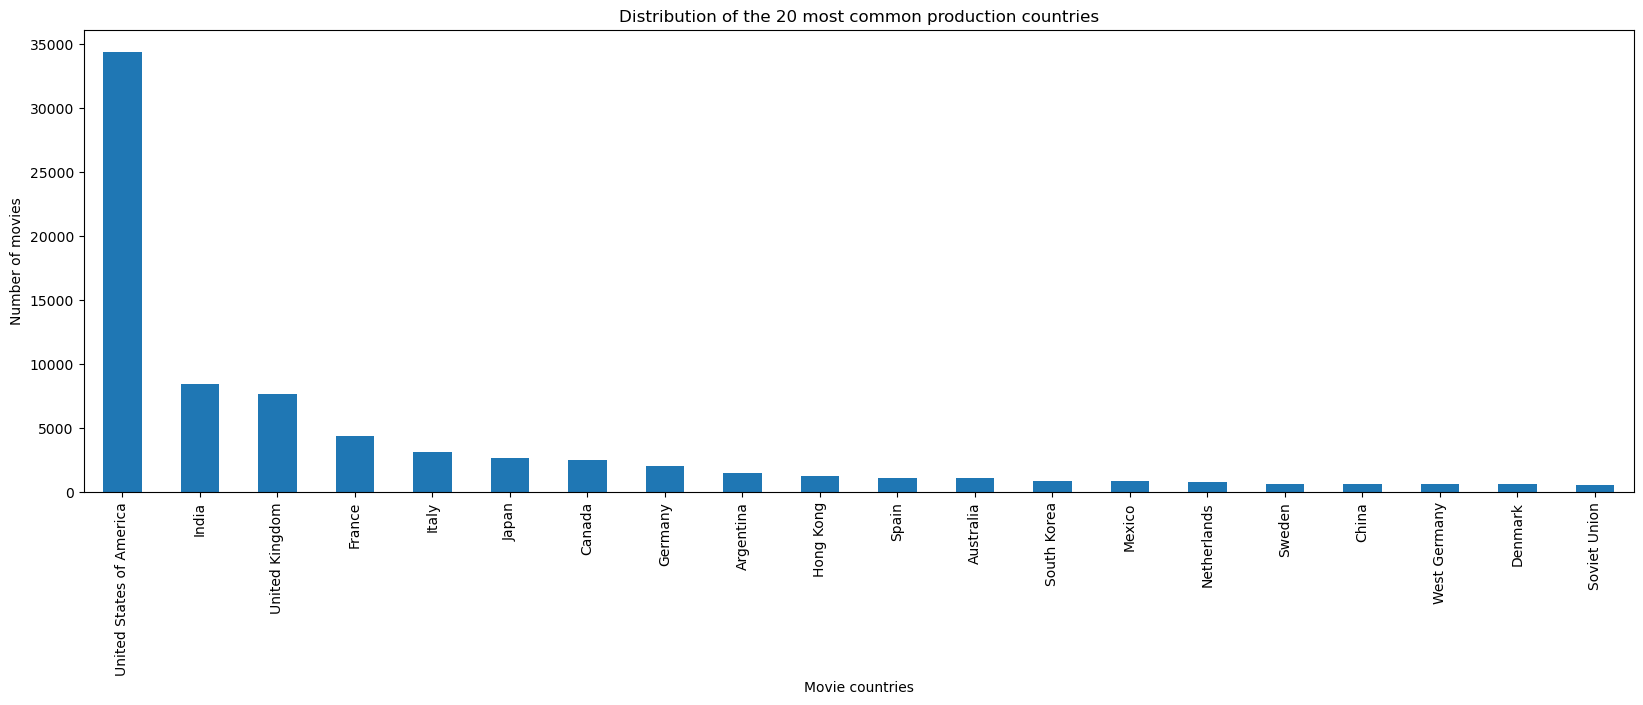

In [16]:
plt.figure(figsize=(20,6))
top20_countries.plot.bar()
plt.title("Distribution of the 20 most common production countries")
plt.xlabel('Movie countries')
plt.ylabel('Number of movies')

In [17]:
genres = movies[['Movie_genre_1', 'Movie_genre_2', 'Movie_genre_3']].apply(pd.Series.value_counts).sum(axis=1)

In [18]:
top20_genres = genres.sort_values(ascending = False)[:20]

Text(0, 0.5, 'Number of movies')

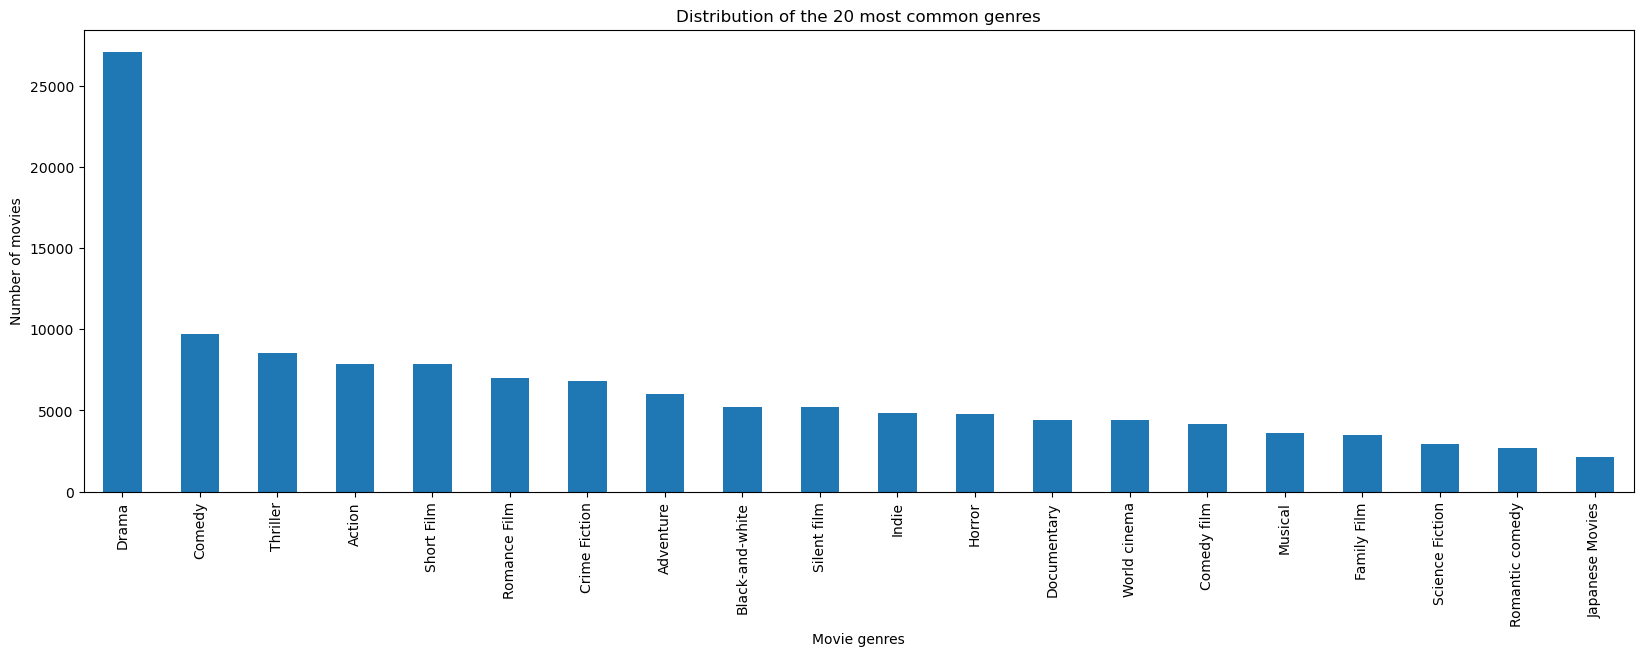

In [19]:
plt.figure(figsize=(20,6))
top20_genres.plot.bar()
plt.title("Distribution of the 20 most common genres")
plt.xlabel('Movie genres')
plt.ylabel('Number of movies')

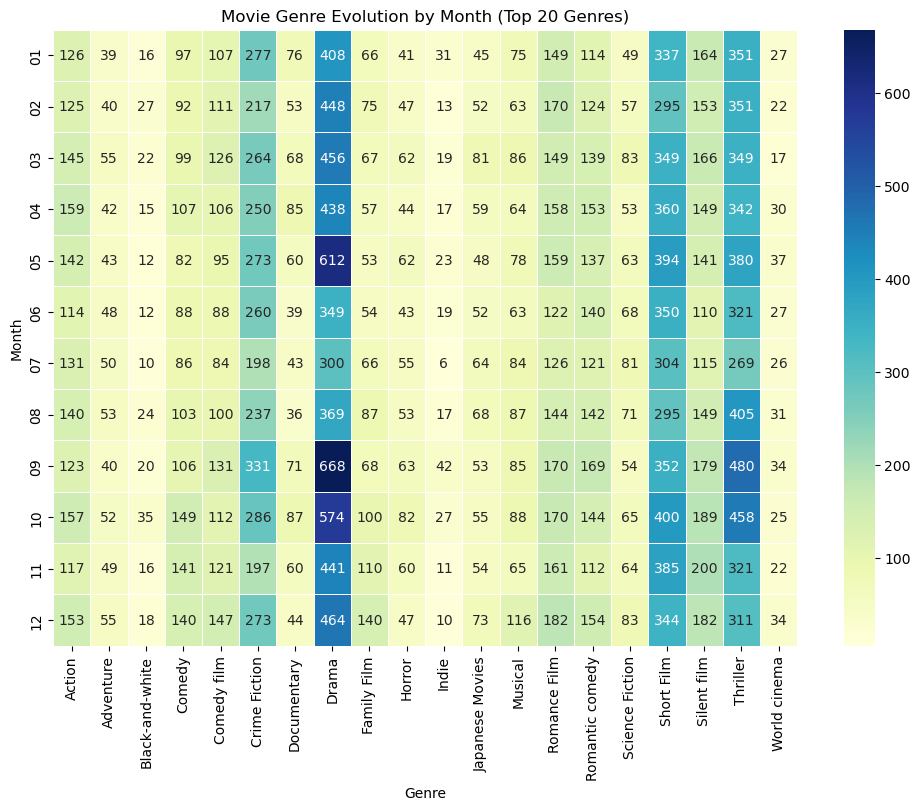

In [20]:
top_20_movies = movies[movies['Movie_genre_1'].isin(top20_genres.index)]

# Group the data by month and genre and calculate the count of movies in each category
genre_month_counts = top_20_movies.groupby(['Movie_release_month', 'Movie_genre_1']).size().unstack(fill_value=0)

# Create a heatmap to visualize the data
plt.figure(figsize=(12, 8))
sns.heatmap(genre_month_counts, cmap='YlGnBu', annot=True, fmt='d', cbar=True, linewidths=0.5)
plt.title('Movie Genre Evolution by Month (Top 20 Genres)')
plt.xlabel('Genre')
plt.ylabel('Month')
plt.show()

In [21]:
# Function to plot % of NaN values

### Modify comments here
def plot_nan(df, title):
    # Calculate the percentage of NaN values in each column
    nan_values = df.isnull().mean() * 100
    # Create a bar plot
    nan_values.plot(kind='bar', figsize=(12,6))
    plt.title(title)
    plt.ylabel('Percentage missing values')
    plt.xlabel('Features')
    plt.show()

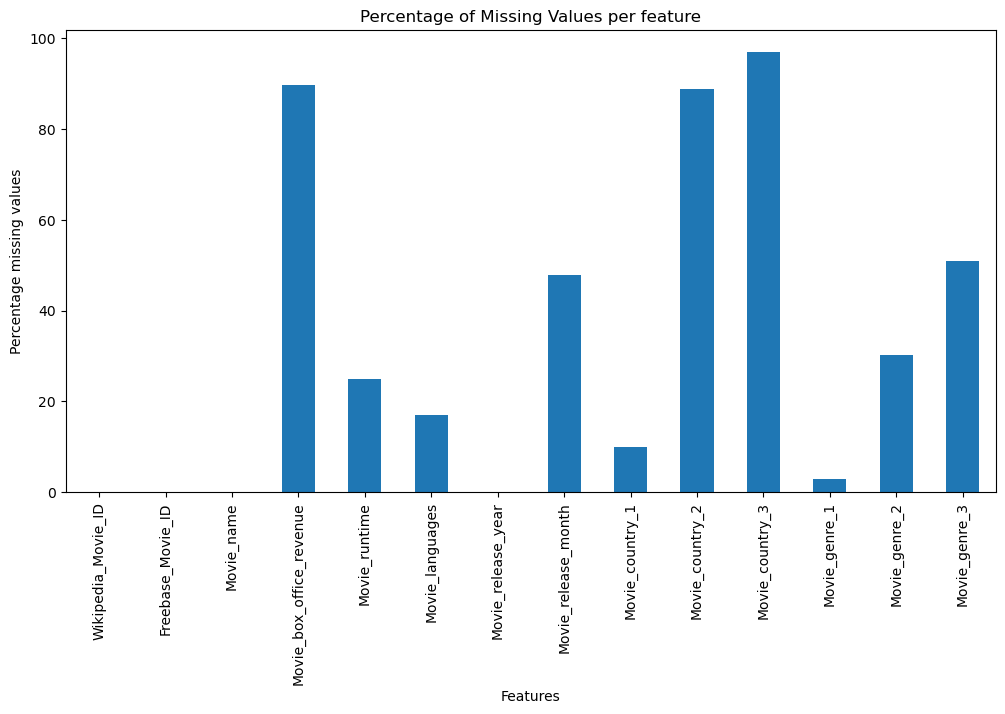

In [22]:
plot_nan(movies, 'Percentage of Missing Values per feature')

As we can see, there are a lot of missing values (about 89%) in the `Movie_box_office_revenue` column. This is an major issue to perform different analysis of the success of a film. This serves as motivation to work with other datasets for our future analysis to complete this one.

Other high values of missing data such as `Movie_country_2` and `Movie_country_3` are not alarming since most of the movies already have information in `Movie_country_1` and may solely have one production country. This is the same for `Movie_genre_`.

#### 2) Characters

In [ ]:
characters.head()

In [ ]:
characters[characters['Freebase_character_map']=='/m/02nwzzv'][:]

In [ ]:
plot_nan(characters, 'Percentage of Missing Values per feature')

In [ ]:
gender_counts = characters.groupby('Actor_gender').size()

In [ ]:
# Plotting a pie chart
fig, ax = plt.subplots()
ax.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=['pink', 'blue'])
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Set the title
plt.title('Gender Repartition of Characters')

# Show the plot
plt.show()

In [ ]:
# It seems like there are some actors with a negatif age. Let us remove them from our data set
characters[characters['Actor_age_at_movie_release'] < 0]

In [ ]:
characters = characters[characters['Actor_age_at_movie_release'] >= 0]
characters['Actor_age_at_movie_release'].hist(bins = 100)
plt.xlabel('Actor age at movie release')
plt.ylabel('Number of actors')
plt.title('Actor age at movie release histogram');

In [ ]:
# Again, it seems that there are some characaters with a height larger than 3 meters...
characters[characters['Actor_height'] > 3].shape

In [ ]:
characters = characters[characters['Actor_height'] < 3]

In [ ]:
characters['Actor_height'].hist(bins = 50)

#### 3) Plot

In [ ]:
columns_plot = ['Film ID', 'Plot summary']

plot = pd.read_table(DATA_FOLDER+'plot_summaries.txt', names=columns_plot)
plot.head()

In [ ]:
movies_with_plot = movies['Wikipedia_Movie_ID'].isin(plot['Film ID']).sum()/len(movies)

print(f'Percentage of films with plots: {movies_with_plot:.2%}')

### Augmenting CMU dataset with IMDb dataset

CMU dataset has a lot of missing values for the `Movie_box_office_revenue` and does not contain any rating for the different movie. Therefore we have chosen to complete CMU dataset with the one of IMDb, which is a a trusted source.

It is possible to join these datasets on the column called "tconst" but to join IMDb dataset with the CMU dataset Wikidata query must be used.

In [28]:
def query_wikidata():
    url = 'https://query.wikidata.org/sparql'
    query = """
    SELECT ?item ?imdb ?freebase WHERE {
      ?item wdt:P345 ?imdb.
      ?item wdt:P646 ?freebase.
    }
    """
    r = requests.get(url, params = {'format': 'json', 'query': query})
    data = r.json()
    return data

In [29]:
def json_to_df(data):
    imdb_ids = []
    freebase_ids = []
    for item in data['results']['bindings']:
        imdb_ids.append(item['imdb']['value'])
        freebase_ids.append(item['freebase']['value'])
    df = pd.DataFrame({'imdb_id': imdb_ids, 'freebase_id': freebase_ids})
    return df

In [30]:
# Load the two files from IMDb

IMDb_path = '../added_data_set/'
basics_df = pd.read_csv(IMDb_path + 'basics.tsv', delimiter='\t', low_memory=False)
ratings_df = pd.read_csv(IMDb_path + 'ratings.tsv', delimiter='\t')

In [31]:
# Inspect the first few rows of the datasets

print("Basics DataFrame:")
print(basics_df.head())
print("\nRatings DataFrame:")
print(ratings_df.head())

Basics DataFrame:
      tconst titleType            primaryTitle           originalTitle  \
0  tt0000001     short              Carmencita              Carmencita   
1  tt0000002     short  Le clown et ses chiens  Le clown et ses chiens   
2  tt0000003     short          Pauvre Pierrot          Pauvre Pierrot   
3  tt0000004     short             Un bon bock             Un bon bock   
4  tt0000005     short        Blacksmith Scene        Blacksmith Scene   

  isAdult startYear endYear runtimeMinutes                    genres  
0       0      1894      \N              1         Documentary,Short  
1       0      1892      \N              5           Animation,Short  
2       0      1892      \N              4  Animation,Comedy,Romance  
3       0      1892      \N             12           Animation,Short  
4       0      1893      \N              1              Comedy,Short  

Ratings DataFrame:
      tconst  averageRating  numVotes
0  tt0000001            5.7      2007
1  tt0000002   

In [32]:
# Get the column names

print("\nBasics DataFrame columns:")
print(basics_df.columns)
print("\nRatings DataFrame columns:")
print(ratings_df.columns)


Basics DataFrame columns:
Index(['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
       'startYear', 'endYear', 'runtimeMinutes', 'genres'],
      dtype='object')

Ratings DataFrame columns:
Index(['tconst', 'averageRating', 'numVotes'], dtype='object')


In [33]:
# Get the number of NaN values in each column

print("\nNumber of NaN values in Basics DataFrame:")
print(basics_df.isnull().sum())
print("\nNumber of NaN values in Ratings DataFrame:")
print(ratings_df.isnull().sum())


Number of NaN values in Basics DataFrame:
tconst             0
titleType          0
primaryTitle      11
originalTitle     11
isAdult            0
startYear          0
endYear            0
runtimeMinutes     0
genres            18
dtype: int64

Number of NaN values in Ratings DataFrame:
tconst           0
averageRating    0
numVotes         0
dtype: int64


In [34]:
# Merge the two IMDb dataframes into 1 using the title

IMDb_df = pd.merge(basics_df,ratings_df, on = 'tconst')

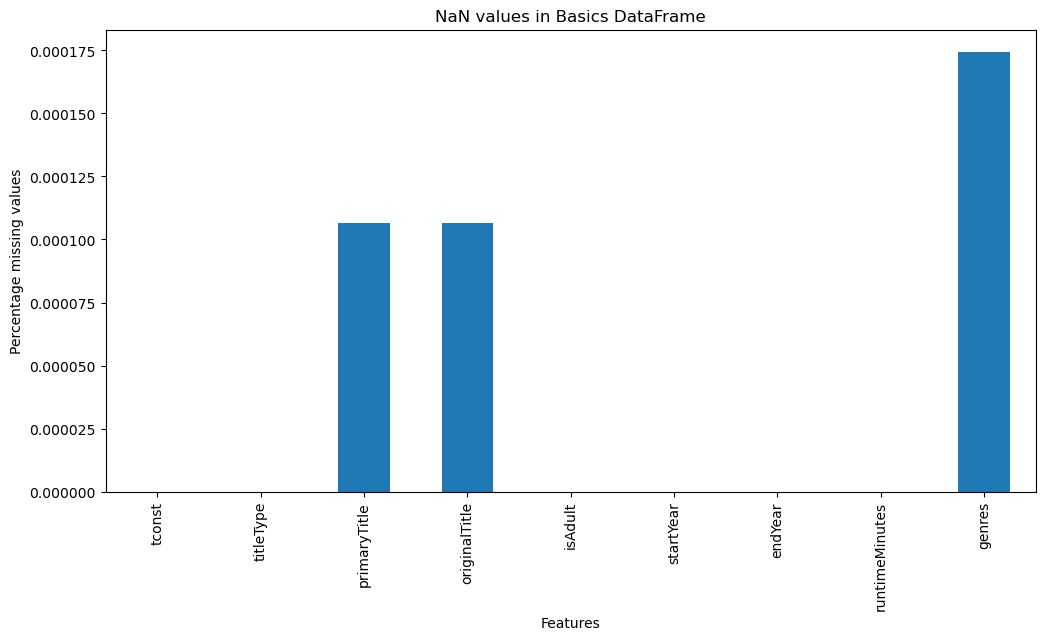

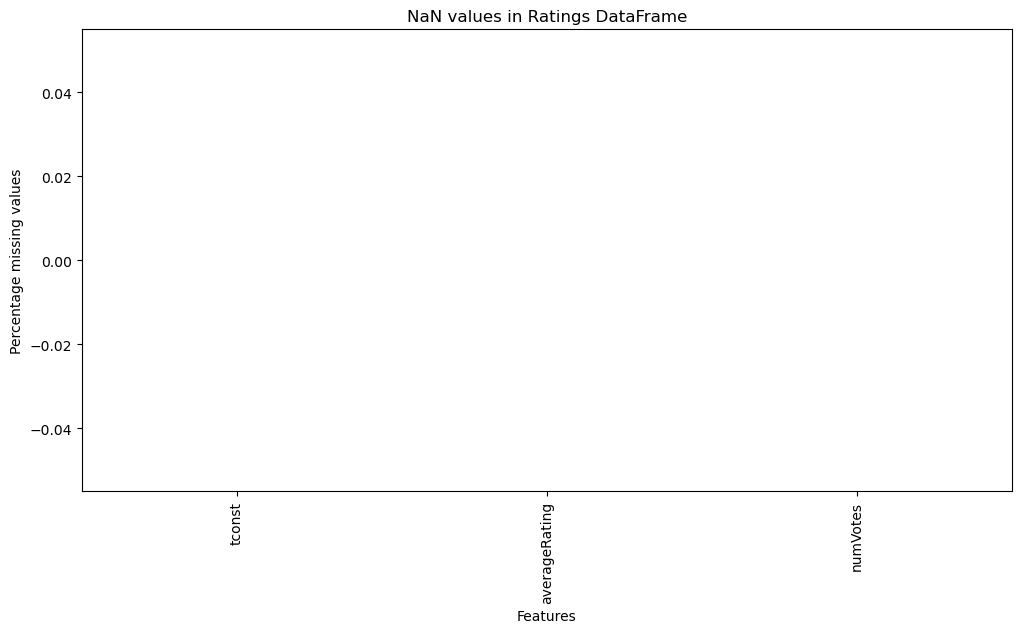

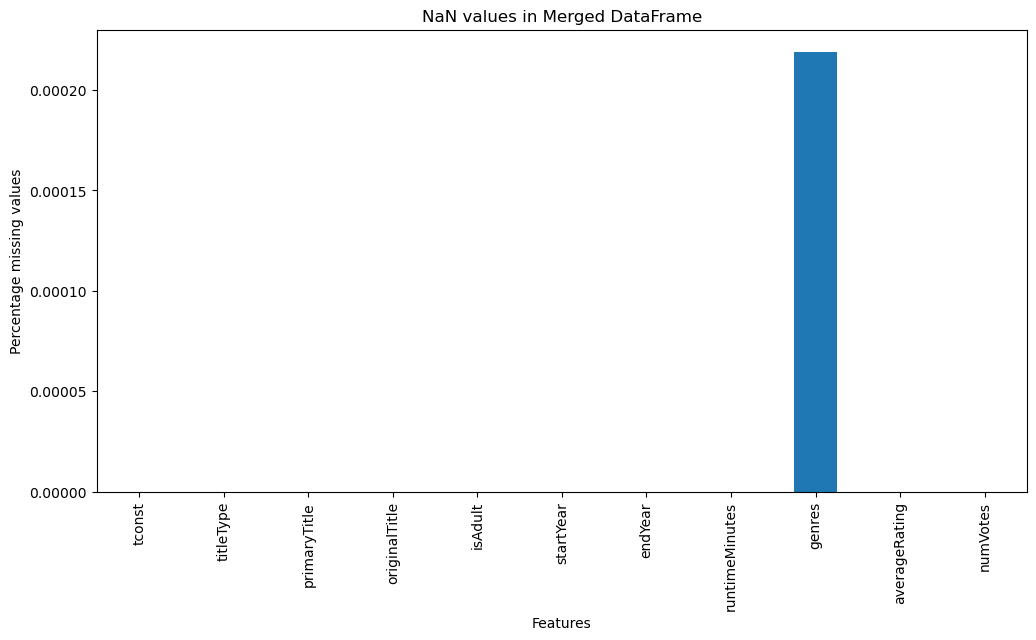

In [35]:
# Plot NaN values

plot_nan(basics_df, 'NaN values in Basics DataFrame')
plot_nan(ratings_df, 'NaN values in Ratings DataFrame')
plot_nan(IMDb_df, 'NaN values in Merged DataFrame')

In [36]:
IMDb_df.sample(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
813516,tt18548250,tvEpisode,Ivankiv Art-World on Fire,Ivankiv Art-World on Fire,0,2022,\N,\N,"Action,Adventure,Biography",9.6,17
1099716,tt4453922,tvEpisode,Episode #1.5,Episode #1.5,0,2015,\N,29,Comedy,7.8,6
854044,tt2065503,tvSeries,Paul Merton's Adventures,Paul Merton's Adventures,0,2011,\N,\N,Documentary,5.8,12
1181417,tt5797184,movie,Escape from Pretoria,Escape from Pretoria,0,2020,\N,106,"Biography,Crime,Mystery",6.8,41798
649226,tt1375542,tvSpecial,George Burns Celebrates 80 Years in Show Business,George Burns Celebrates 80 Years in Show Business,0,1983,\N,90,"Comedy,Music",7.8,16


In [37]:
IMDb_df.columns, movies.columns

(Index(['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
        'startYear', 'endYear', 'runtimeMinutes', 'genres', 'averageRating',
        'numVotes'],
       dtype='object'),
 Index(['Wikipedia_Movie_ID', 'Freebase_Movie_ID', 'Movie_name',
        'Movie_box_office_revenue', 'Movie_runtime', 'Movie_languages',
        'Movie_release_year', 'Movie_release_month', 'Movie_country_1',
        'Movie_country_2', 'Movie_country_3', 'Movie_genre_1', 'Movie_genre_2',
        'Movie_genre_3'],
       dtype='object'))

In [38]:
data = query_wikidata()

In [39]:
wikidata_df = json_to_df(data)

In [40]:
# The merge below is to keep ONLY the films that are in the cmu_df and in IMDb_df

# Merge cmu_df with wikidata_df
merged_df = movies.merge(wikidata_df, how='inner', left_on='Freebase_Movie_ID', right_on='freebase_id')

# Merge the result with IMDb_df
merged_df = merged_df.merge(IMDb_df, how='inner', left_on='imdb_id', right_on='tconst')

In [41]:
merged_df.size, IMDb_df.size, movies.size

(1835406, 15058120, 1144374)

In [42]:
merged_df.sample(5)

,Wikipedia_Movie_ID,Freebase_Movie_ID,Movie_name,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_release_year,Movie_release_month,Movie_country_1,Movie_country_2,...,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
21255,34012751,/m/0hr1f1c,Hum Bhi Insaan Hain,NaN,NaN,[Hindi],1948,None,India,NaN,...,movie,Hum Bhi Insaan Hain,Hum Bhi Insaan Hain,0,1948,\N,\N,Drama,7.7,19
27323,15585766,/m/03mglpl,The Rats of Tobruk,NaN,68.0,[English],1944,None,Australia,NaN,...,movie,The Rats of Tobruk,The Rats of Tobruk,0,1944,\N,68,"Action,Drama,War",5.4,294
47958,20823557,/m/055z0rs,The System,NaN,93.0,[English],1964,09,United Kingdom,NaN,...,movie,The Girl-Getters,The System,0,1964,\N,93,Drama,6.5,791
44397,28798125,/m/0ddhn8c,Warning to Wantons,NaN,98.0,[English],1949,None,United Kingdom,NaN,...,movie,Warning to Wantons,Warning to Wantons,0,1949,\N,105,"Comedy,Romance",5.4,48
20184,1623267,/m/05hh4s,The Last Dragon,25784554.0,108.0,[English],1985,03,United States of America,NaN,...,movie,The Last Dragon,The Last Dragon,0,1985,\N,109,"Action,Comedy,Drama",6.8,17070


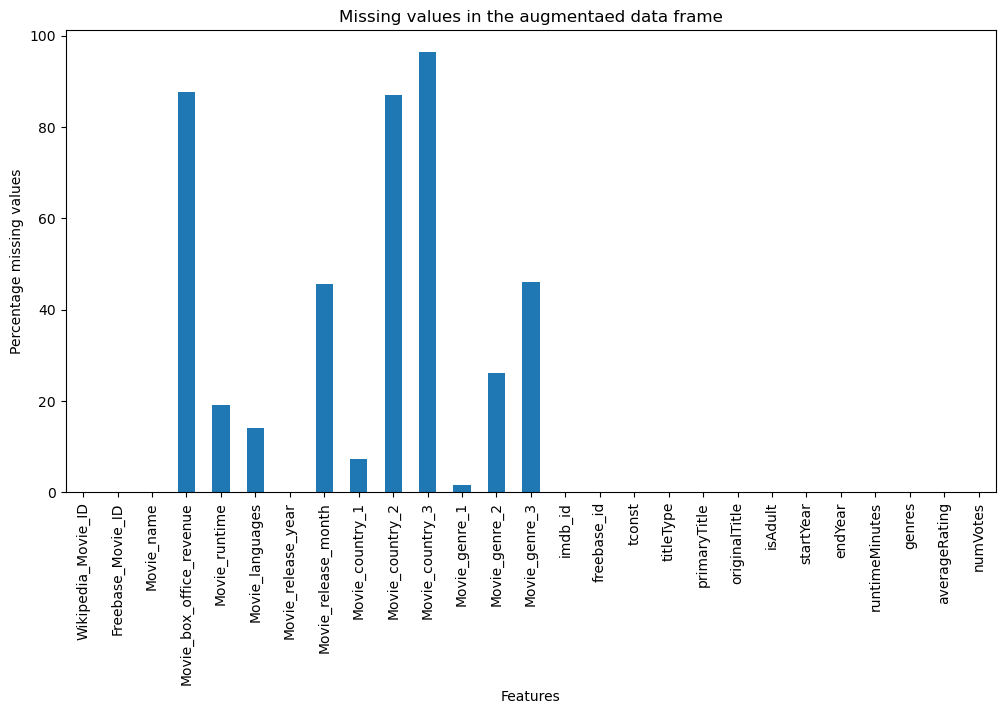

In [43]:
plot_nan(merged_df, 'Missing values in the augmentaed data frame')

In [44]:
print(len(merged_df), len(movies))

67978 81741


### First stage analysis of impact of the production country

In [ ]:
df_top20_genre_country = merged_df[(merged_df['Movie_genre_1'].isin(top20_genres.index))&
                        (merged_df['Movie_country_1'].isin(top20_countries.index))]

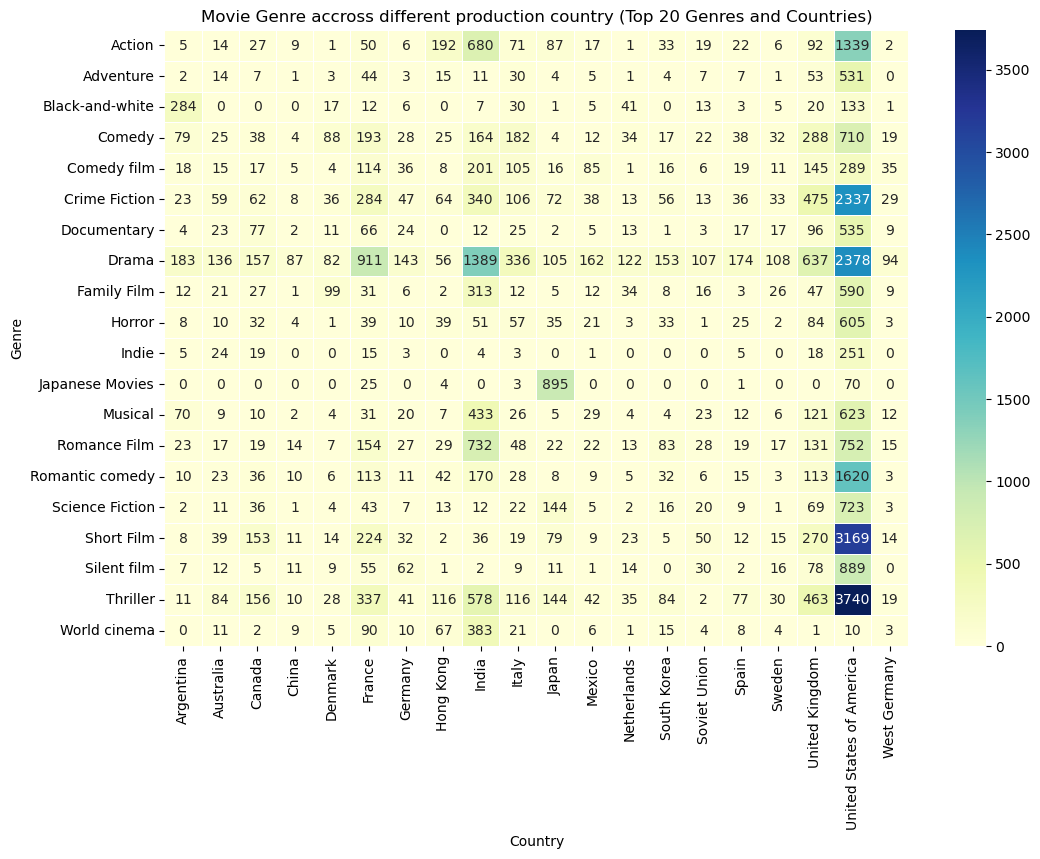

In [45]:
# Group the data by genre and genre and calculate the count of movies in each category
genre_country_counts = df_top20_genre_country.groupby(['Movie_genre_1', 'Movie_country_1']).size().unstack(fill_value=0)

# Create a heatmap to visualize the data
plt.figure(figsize=(12, 8))
sns.heatmap(genre_country_counts, cmap='YlGnBu', annot=True, fmt='d', cbar=True, linewidths=0.5)
plt.title('Movie Genre accross different production country (Top 20 Genres and Countries)')
plt.xlabel('Country')
plt.ylabel('Genre')
plt.show()

In [51]:
df_top20_countries = merged_df[merged_df['Movie_country_1'].isin(top20_countries.index)]

Text(0, 0.5, 'Numbers')

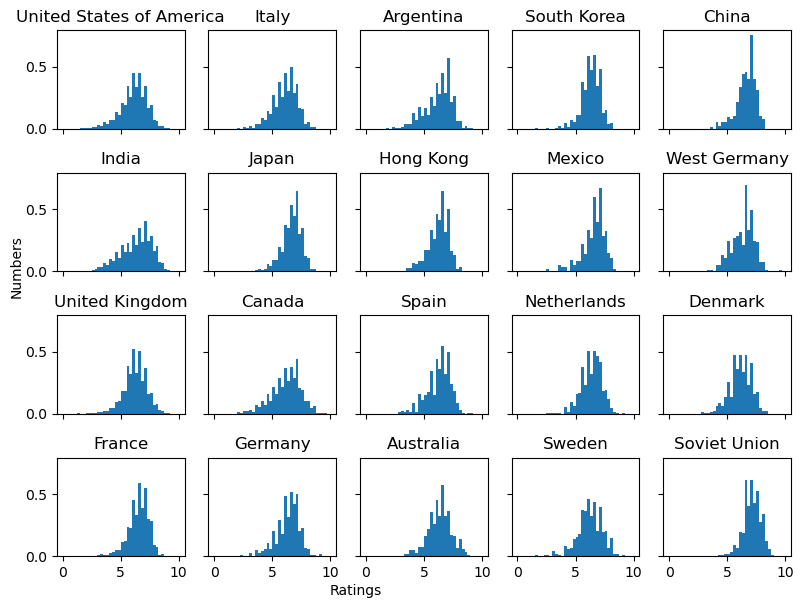

In [52]:
country = merged_df.groupby('Movie_country_1')

fig, ax = plt.subplots(4,5,figsize= (8,6), sharey = True, sharex = True)

for i, name in enumerate(top20_countries.index):
    sbplt = ax[i%4, i//4]
    sbplt.hist(country.get_group(name).averageRating, range = [0,10], density=True, bins = 40)
    sbplt.set_title(name)

    
fig.tight_layout()

fig.text(0.4,0, "Ratings")
fig.text(0,0.5, "Numbers", rotation = 90)

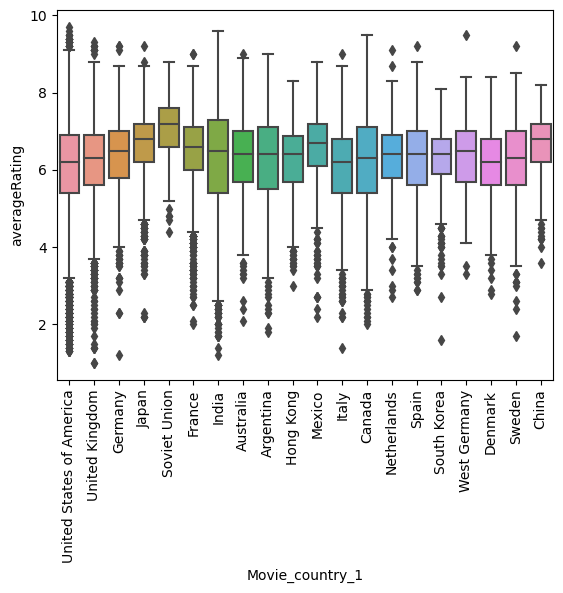

In [53]:
ax = sns.boxplot(x="Movie_country_1", y="averageRating", data=df_top20_countries)

plt.setp(ax.get_xticklabels(), rotation=90);

In [62]:
df_american_movies = merged_df[merged_df['Movie_country_1']=='United States of America']
df_top20_genre_american = df_american_movies[df_american_movies['Movie_genre_1'].isin(top20_genres.index)]

df_top20_genre_american.head()

,Wikipedia_Movie_ID,Freebase_Movie_ID,Movie_name,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_release_year,Movie_release_month,Movie_country_1,Movie_country_2,...,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,[English],2001,08,United States of America,NaN,...,movie,Ghosts of Mars,Ghosts of Mars,0,2001,\N,98,"Action,Horror,Sci-Fi",4.9,56928
5,13696889,/m/03cfc81,The Gangsters,NaN,35.0,"[Silent film, English]",1913,05,United States of America,NaN,...,short,The Gangsters,The Gangsters,0,1913,\N,35,"Comedy,Short",6.8,17
6,10408933,/m/02qc0j7,Alexander's Ragtime Band,3600000.0,106.0,[English],1938,08,United States of America,NaN,...,movie,Alexander's Ragtime Band,Alexander's Ragtime Band,0,1938,\N,106,"Drama,Music,Musical",6.8,2268
8,175026,/m/017n1p,Sarah and Son,NaN,86.0,[English],1930,None,United States of America,NaN,...,movie,Sarah and Son,Sarah and Son,0,1930,\N,86,"Drama,Romance",5.4,300
10,6631279,/m/0gffwj,Little city,NaN,93.0,[English],1997,04,United States of America,NaN,...,movie,Little City,Little City,0,1997,\N,90,"Comedy,Romance",5.8,1129


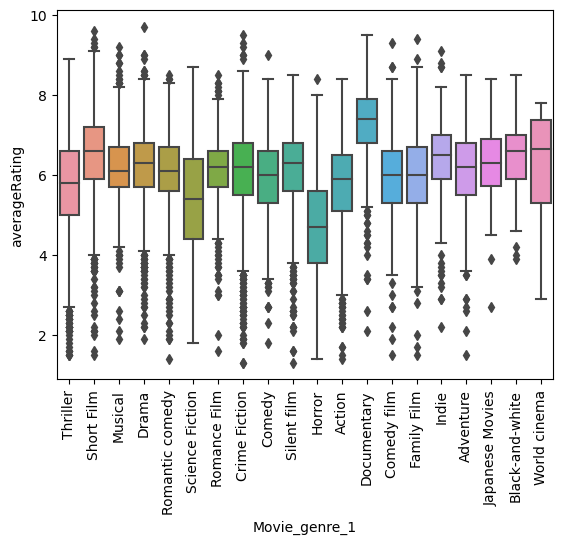

In [63]:
ax = sns.boxplot(x="Movie_genre_1", y="averageRating", data=df_top20_genre_american)

plt.setp(ax.get_xticklabels(), rotation=90);

In [ ]:
ax = sns.boxplot(x="Movie_runtime", y="averageRating", data=merged_df)

plt.setp(ax.get_xticklabels(), rotation=90);

In [ ]:
sns.jointplot(data=merged_df, x = "Movie_runtime", y = "averageRating", kind="reg")

In [ ]:
movies_copy = movies.dropna()

print(stats.pearsonr(movies_copy['Movie_runtime'], movies_copy['Movie_box_office_revenue']))